In [39]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from scipy.stats import pearsonr
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objs as go
from elasticsearch import Elasticsearch

## Data processing

The below data will be used for this model:

### Response variable: Regional population dataset

This dataset contains the population related information in Victoria, ranging from births, deaths to migration.
The key feature that we're interested in is the erp_YYYY column, which holds the estimated regional population for Melbourne


In [40]:

INDEX_NAME = "abs-regional_population_lga_2001-2021"

es_client = Elasticsearch (
        'https://localhost:9200',
        verify_certs= False,
        ssl_show_warn= False,
        basic_auth=('elastic', 'elastic')
    )
es_client.indices.refresh(index=INDEX_NAME)
result = es_client.search(index=INDEX_NAME, body = {
'size' : 1000,
'query': {
    'match_all' : {}
}
})


es_data = []
for doc in result['hits']['hits']:
    es_data.append(doc['_source'])
response = pd.DataFrame(es_data)





### Cleaning up of response dataset
For retriving data of region = melbourne

In [41]:
# Remove spacing from column names

response.columns = response.columns.str.replace(' ', '')

In [42]:
# Get all key columns for our response dataset. The years range from 2011 to 2021, inclusive of start & end. 

KEY_RESPONSE_COLUMNS = ['lga_name_2021']

for i in range(2011, 2022):
    key_column = f"erp_{i}"
    KEY_RESPONSE_COLUMNS.append(key_column)
    

In [43]:
# Pick out row 7 to turn into dataframe ( melbourne)

response_clean = pd.DataFrame(response[KEY_RESPONSE_COLUMNS].iloc[7]).reset_index()

In [44]:
# Rename and clean columns

response_clean = response_clean.rename(columns={'index': 'year', 7: 'population'})
response_clean = response_clean.iloc[1:] # Remove unnceessary row
response_clean['year'] = response_clean['year'].str.removeprefix('erp_')
response_clean['year'] = response_clean['year'].astype(int)

In [45]:
response_clean

,year,population
1,2011,87395
2,2012,88339
3,2013,89188
4,2014,90417
5,2015,91674
6,2016,93445
7,2017,95071
8,2018,96481
9,2019,97765
10,2020,98146


liviablility dataset

In [46]:

INDEX_NAME = "liveability-index"

es_client = Elasticsearch (
        'https://localhost:9200',
        verify_certs= False,
        ssl_show_warn= False,
        basic_auth=('elastic', 'elastic')
    )
es_client.indices.refresh(index=INDEX_NAME)
result = es_client.search(index=INDEX_NAME, body = {
'size' : 1000,
'query': {
    'match_all' : {}
}
})


es_data = []
for doc in result['hits']['hits']:
    es_data.append(doc['_source'])
liveability = pd.DataFrame(es_data)




Firstly, we need to be able to condense both of the datasets into year so that we can model easier. For the liveability score, we'll combine numerator + denominator for a whole year, then calculate a new percentage for said year. Further, we only want percentages for our dataset since counts will not give us any relevant predictions, as we do not need to create a model but rather see some correlation between the 2 datasets

In [47]:
# Get the subset of the dataframe with the data we want

liveability = liveability[liveability['type'] == 'Liveability']
liveability = liveability[liveability['value_type'] == 'Percentage']
liveability['period'] = liveability['period'].str.extract(r'(\d{4})')
set(liveability['topic']) 

{'Economy',
 'Finance',
 'Governance',
 'Profile - housing, government and economy',
 'Profile - people',
 'Transportation'}

In [48]:
# Then remove all NaN values

# Replace 'N/A' and other similar variations with NaN

liveability.replace(['N/A', 'n/a', 'NA'], pd.NA, inplace=True)


liveability = liveability.dropna(subset=['numerator', 'denominator'])



In [49]:
liveability

,type,topic,id,indicator,period,numerator,denominator,value,value_type,sources
0,Liveability,Economy,ECO_2,Assessed value of commercial and industrial pr...,2015,"48,331,069,777.00","101,671,404,180.00",47.540,Percentage,"City of Melbourne, Property Services, 2015-2018"
1,Liveability,Economy,ECO_4,Percentage of persons (city population) in ful...,2017,"68,722","159,141",43.180,Percentage,"Geografia, Relative Poverty and Employment Mea..."
2,Liveability,Finance,FIN_1,Debt service ratio (debt service expenditure a...,2017,"995,000.00","420,287,000.00",0.237,Percentage,1-3. City of Melbourne Annual Report 2017-18; ...
3,Liveability,Finance,FIN_2,Capital spending as a percentage of total expe...,2016,"78,325,000.00","492,430,000.00",15.910,Percentage,1-3. City of Melbourne Annual Report 2017-18; ...
4,Liveability,Finance,FIN_4,Tax collected as a percentage of tax billed,2014,"228,981,000.00","226,920,000.00",100.910,Percentage,1-3. City of Melbourne Annual Report 2017-18; ...
...,...,...,...,...,...,...,...,...,...,...
292,Liveability,Governance,GOV_5,Number of registered voters as a percentage of...,2012,"108,434","85,413",126.950,Percentage,"1. Victorian Electoral Commission, 2017 (obtai..."
302,Liveability,Profile - people,PROP_10,Percentage of population that are adults (25-6...,2015,"78,797","136,872",57.570,Percentage,"1. Australian Bureau of Statistics, 3235.0 Reg..."
304,Liveability,Profile - people,PROP_5,Percentage of population that are seniors (65+),2016,"9,709","146,096",6.650,Percentage,"Australian Bureau of Statistics, Census of Pop..."
305,Liveability,Profile - people,PROP_8,Percentage of population that are new immigrants,2016,"40,433","135,959",29.740,Percentage,"Australian Bureau of Statistics, Census of Pop..."


In [50]:
# Turn all numerical columns into int for calculation

liveability['numerator'] = liveability['numerator'].astype(str).str.replace(',', '').astype(float).astype(int)
liveability['denominator'] = liveability['denominator'].astype(str).str.replace(',', '').astype(float).astype(int)

In [51]:
liveability[liveability['indicator'] == 'Percentage of country GDP']

,type,topic,id,indicator,period,numerator,denominator,value,value_type,sources
13,Liveability,"Profile - housing, government and economy",PROH_8,Percentage of country GDP,2013,1464955475993,83367000000,5.69,Percentage,"1. The World Bank data, GDP (current US$) for ..."
132,Liveability,"Profile - housing, government and economy",PROH_8,Percentage of country GDP,2016,1323421072479,73043232000,5.52,Percentage,"1. The World Bank data, GDP (current US$) for ..."
133,Liveability,"Profile - housing, government and economy",PROH_8,Percentage of country GDP,2015,1208039015868,68408312000,5.66,Percentage,"1. The World Bank data, GDP (current US$) for ..."
193,Liveability,"Profile - housing, government and economy",PROH_8,Percentage of country GDP,2014,1349034029453,69580800000,5.16,Percentage,"1. The World Bank data, GDP (current US$) for ..."


After a qucik look, for some reason the numerator & denominator for all GDP related rows are swapped. Further, even if we did swap the columns around for appropriate values, the numbers are much greater than the other values used for calculation, thus adding these values in will skew our data so that the majority of the percentage calculation would come from these 2 rows. Thus, opt to remove these rows

In [52]:
liveability = liveability[liveability['indicator'] != 'Percentage of country GDP']

In [53]:
liveability[liveability['period'] == '2014']

,type,topic,id,indicator,period,numerator,denominator,value,value_type,sources
4,Liveability,Finance,FIN_4,Tax collected as a percentage of tax billed,2014,228981000,226920000,100.91,Percentage,1-3. City of Melbourne Annual Report 2017-18; ...
73,Liveability,Finance,FIN_3,Own-source revenue as a percentage of total re...,2014,378466000,435777000,86.85,Percentage,1-3. City of Melbourne Annual Report 2017-18; ...
89,Liveability,Profile - people,PROP_4,Percentage of population that are youth (15-24...,2014,36701,127975,28.68,Percentage,"Australian Bureau of Statistics, Census of Pop..."
92,Liveability,Profile - people,PROP_9,Percentage of population that are children (0-...,2014,8777,127975,6.86,Percentage,"Australian Bureau of Statistics, Census of Pop..."
114,Liveability,Economy,ECO_4,Percentage of persons (city population) in ful...,2014,55359,127975,43.26,Percentage,"Geografia, Relative Poverty and Employment Mea..."
115,Liveability,Economy,ECO_5,Youth unemployment rate,2014,1367,13048,10.48,Percentage,"Geografia, Relative Poverty and Employment Mea..."
117,Liveability,Finance,FIN_2,Capital spending as a percentage of total expe...,2014,82078000,457698000,17.93,Percentage,1-3. City of Melbourne Annual Report 2017-18; ...
125,Liveability,Governance,GOV_3,Percentage of women employed in the city gover...,2014,1019,2631,38.73,Percentage,1-3. City of Melbourne Annual Report 2017-18; ...
160,Liveability,Profile - people,PROP_12,Population dependency ratio (people aged under...,2014,13,86,15.52,Percentage,"1. Australian Bureau of Statistics, 3235.0 Reg..."
161,Liveability,Profile - people,PROP_5,Percentage of population that are seniors (65+),2014,8413,127975,6.57,Percentage,"Australian Bureau of Statistics, Census of Pop..."


In [57]:
liveability_clean = liveability[['period', 'numerator', 'denominator']].groupby('period').sum().reset_index()
liveability_clean['percentage'] = ((liveability_clean['numerator'] * 100)/liveability_clean['denominator']).round(2)
liveability_clean.rename(columns={'period': 'year'}, inplace=True)
liveability_clean['year'] = response_clean['year'].astype(int)

In [58]:
liveability_final = liveability_clean[['year', 'percentage']]

In [59]:
liveability_final

,year,percentage
0,NaN,51.20
1,2011.0,52.91
2,2012.0,89.50
3,2013.0,9.49
4,2014.0,45.99
5,2015.0,47.51
6,2016.0,48.43
7,2017.0,47.85
8,2018.0,45.37


In [60]:
analysis_df = pd.merge(liveability_final, response_clean, on='year')
analysis_df['year'] = pd.to_numeric(analysis_df['year'])
analysis_df['percentage'] = pd.to_numeric(analysis_df['percentage'])
analysis_df['population'] = pd.to_numeric(analysis_df['population'])

In [61]:
analysis_df

,year,percentage,population
0,2011.0,52.91,87395
1,2012.0,89.50,88339
2,2013.0,9.49,89188
3,2014.0,45.99,90417
4,2015.0,47.51,91674
5,2016.0,48.43,93445
6,2017.0,47.85,95071
7,2018.0,45.37,96481


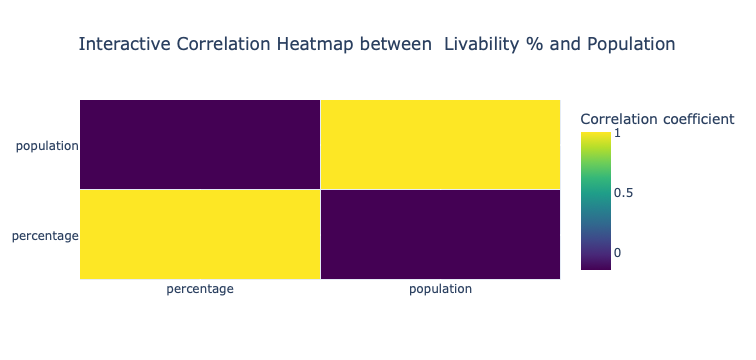

In [66]:

# Calculate correlation matrix
corr_matrix = analysis_df[['percentage', 'population']].corr()

# Create an interactive heatmap using Plotly
heatmap_fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    xgap=1, ygap=1,
    colorscale='Viridis',
    colorbar_title='Correlation coefficient',
))

heatmap_fig.update_layout(title_text='Interactive Correlation Heatmap between  Livability % and Population', title_x=0.5)

# Show the plot
heatmap_fig.show()